### Importing Python Libraries

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

from statistics import mean
import random
import time

### Loading the Mnist Dataset

In [2]:
def dataset_load(root="../mnist_project/data"):    
    train_data = torchvision.datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=False)
    test_tens = torchvision.datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=False)
    
    train_tens, val_tens = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
    return train_tens, val_tens, test_tens

In [3]:
train_tensor, val_tensor, test_tensor = dataset_load()

### Lengths of our subsets

In [4]:
len(train_tensor), len(val_tensor), len(test_tensor)

(50000, 10000, 10000)

### Random sample shape - 28x28 picture

In [5]:
train_tensor[0][0].shape, train_tensor[0][1]

(torch.Size([1, 28, 28]), 6)

### Iterating and Visualizing the dataset

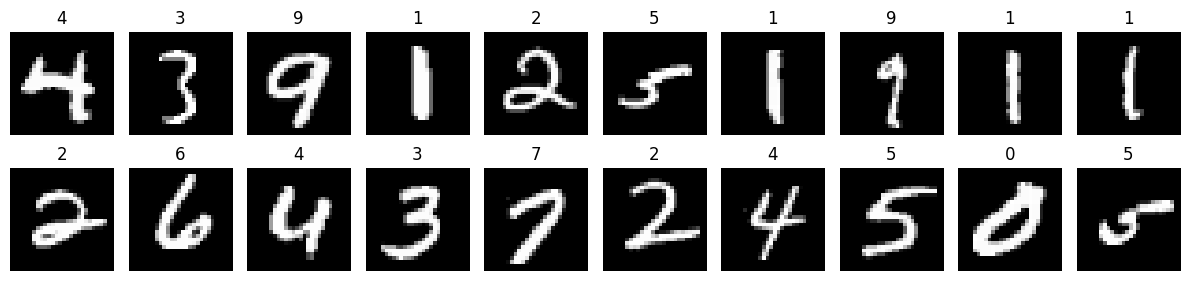

In [6]:
rand_idx = random.sample(range(0, len(train_tensor)), 20)

figure = plt.figure(figsize=(12, 3), tight_layout=True)

for i in range(len(rand_idx)):
    img, label = train_tensor[rand_idx[i]]
    figure.add_subplot(2, 10, i+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# ***Data loaders***
###

In [7]:
def data_loader(data, is_train, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=is_train, num_workers=1)

In [8]:
def test_loader(data, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size)

## Testing data loaders
#####
#### It takes around 3/4 seconds to iterate through whole test set - ***50 thousands examples***.

In [9]:
tic = time.time()
for X, y in data_loader(train_tensor, True, 256):
    continue
f'{time.time() - tic:.2f} sec'

'3.16 sec'

## Analizing batch content
#####
#### Feature tensor ***X_1*** contains given amount of 28x28 images with one gray-scale channel. 
#### Label tensor ***y_1*** (1D Tensor) contains categorical labels, where each element is an integer in the range 0-9.

In [10]:
X_1, y_1 = next(iter(data_loader(train_tensor, True, 64))) 
print("Shapes:", X_1.shape, X_1.dtype, y_1.shape, y_1.dtype, '\n')
print(y_1, '\n')
print(X_1.min(), X_1.max()) # 0 - black | 1 - white

Shapes: torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64 

tensor([6, 8, 5, 6, 6, 2, 8, 6, 3, 0, 9, 4, 9, 8, 0, 6, 7, 5, 7, 5, 4, 0, 4, 5,
        0, 5, 9, 5, 2, 8, 2, 6, 0, 1, 1, 4, 4, 6, 0, 6, 1, 4, 6, 3, 4, 7, 1, 2,
        6, 1, 6, 2, 2, 9, 1, 5, 3, 9, 2, 7, 6, 3, 6, 7]) 

tensor(0.) tensor(1.)


#####
## Visualizing batch elements to verify label-image alignment.

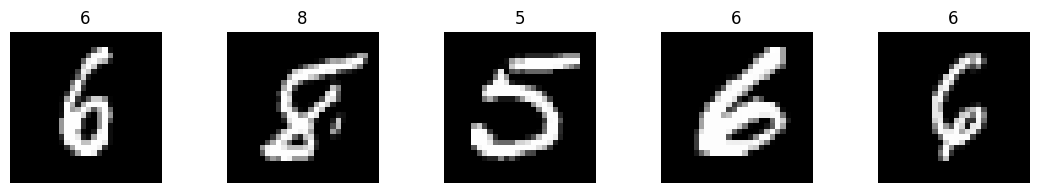

In [11]:
rand_idx = random.sample(range(0, 64), 5)
figure = plt.figure(figsize=(11, 2), tight_layout=True)
for i in range(len(rand_idx)):
    img, label = X_1[i], y_1[i]
    figure.add_subplot(1, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# ***Core Classes***
### This section defines the main classes used by all models in this project.

###
## Plotter Class
#### Simple class using ***MatPlotLib*** library used for visualizing train/val loss.

In [39]:
class Plotter():
    def __init__(self, title):
        self.title = title

    def plot(self, train_losses, val_losses, accuracy):
        clear_output(wait=True) 
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(epochs, train_losses, label=f"Train loss: {train_losses[-1]:.4f}")
        plt.plot(epochs, val_losses, label=f"Val loss: {val_losses[-1]:.4f}")
        plt.plot(epochs, accuracy, label=f"Val acc: {accuracy[-1]:.4f}")
        plt.xlabel("Epoch")
        plt.title(self.title)
        plt.legend()
        plt.show()

###
## Trainer Class
#### A lightweight training utility implemented to standardize the training loop across experiments.

In [42]:
class Trainer():
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs

    def prepare_data(self, train_data, val_data):
        self.train_dataloader = data_loader(train_data, True, 256)
        self.val_dataloader = data_loader(val_data, False, 256)     

        
    def fit(self, model, train_data, val_data, plotter):
        self.prepare_data(train_data, val_data)
        model.trainer = self
        self.model = model
        self.optim = model.config_optim()
        
        self.plotter = plotter
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.val_accuracy_epoch = []
        
        for _ in range(self.num_epochs):
            self.fit_epoch()
            self.plotter.plot(self.train_losses_epoch, self.val_losses_epoch, self.val_accuracy_epoch)

    def fit_epoch(self):
        train_losses_batch = []
        val_losses_batch = []
        val_accuracy = []
        
        self.model.train()
        for batch in self.train_dataloader:
            loss, _ = self.model.batch_step(batch)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            train_losses_batch.append(loss.item())
            
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                l, acc = self.model.batch_step(batch)
                val_losses_batch.append(l.item())
                val_accuracy.append(acc.item())
                
        self.train_losses_epoch.append(mean(train_losses_batch))
        self.val_losses_epoch.append(mean(val_losses_batch))  
        self.val_accuracy_epoch.append(mean(val_accuracy))

# ***Base Linear Model***
### In this section we create baseline simple linear model that will be used for comparing later models.
###

## Model Class
#### Simple linear model with ***Stochastic Gradient Descent*** optimizer and ***Cross-Entropy Loss***.

In [43]:
class BaseModel(nn.Module):
    def __init__(self, lr, num_outputs):
        super().__init__()
        self.lr = lr
        self.num_outputs = num_outputs
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(self.num_outputs))

    def forward(self, X):
        return self.net(X)

    def ce_loss(self, Y_hat, Y):
        return F.cross_entropy(Y_hat, Y, reduction='mean')

    def config_optim(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def batch_step(self, batch):
        Y_hat = self.forward(batch[0])
        l = self.ce_loss(Y_hat, batch[1])
        acc = (Y_hat.argmax(dim=1) == batch[1]).float().mean()
        return l, acc

## Training

### - Learning rate `0.01`

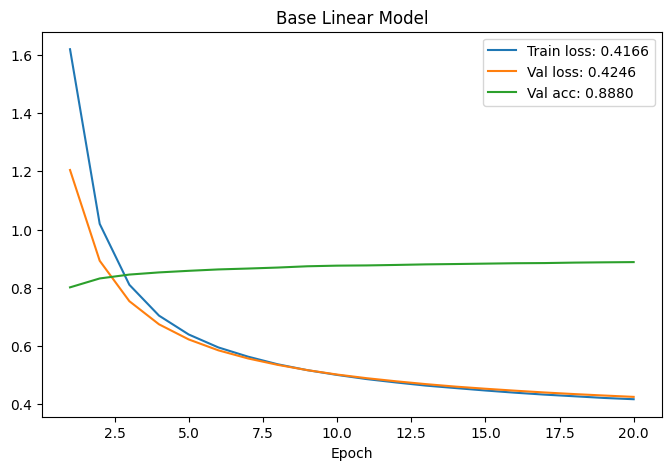

In [44]:
base_model = BaseModel(0.01, 10)
plotter = Plotter("Base Linear Model")
base_trainer = Trainer(20)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)

### - Learning rate `0.05`
#####

#### It can be clearly seen that higher learning rate achieves lower train/val loss, meaning that </br>previous value ***0.01*** was too low for 20 epochs.

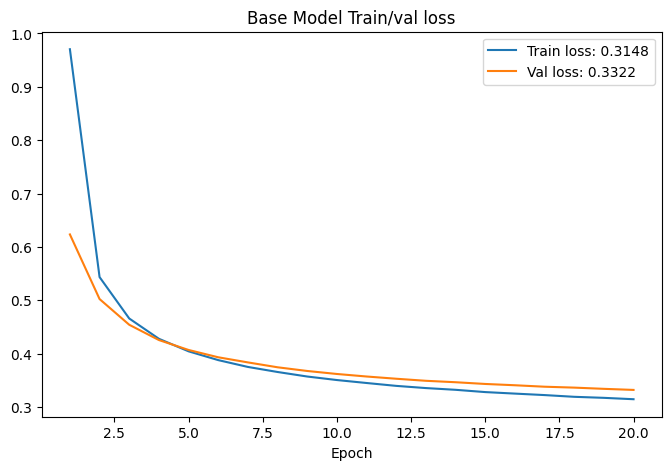

In [34]:
base_model = BaseModel(0.05, 10)
plotter = Plotter("Base Model Train/val loss")
base_trainer = Trainer(20)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)

### - Learning rate `0.1`
#####

#### Suprisingly, increasing learning rate to ***0.1*** did not yield any significant improvements.</br> This suggests that number of epochs may be too small or model has reached peak in its limited capacity. 

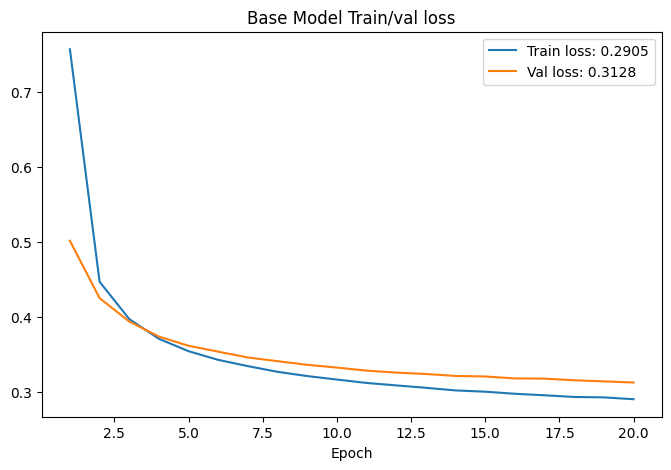

In [20]:
base_model = BaseModel(0.1, 10)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)

### Visualizing Falsely predicted Numbers

In [15]:
def plot_false_predic(zipped):
    figure = plt.figure(figsize=(12, 3), tight_layout=True)
    for i, (img, f_label) in enumerate(zipped):
        figure.add_subplot(2, 10, i+1)
        plt.title(f_label.item())
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [23]:
def false_predic(data_loader):
    images, labels = data_loader
    
    with torch.no_grad():
        predic_labels = torch.argmax(F.softmax(base_model.forward(images), dim=1), dim=1)
    mask = (predic_labels != labels)
    
    diff_imgs = images[mask]
    diff_lbs = predic_labels[mask]
    print(f"False labels in batch: {diff_imgs.size(0)}\n")
    sample_num = min(20, diff_imgs.size(0))
    indices = torch.randperm(diff_imgs.size(0))[:sample_num]
    
    plot_false_predic(zip(diff_imgs[indices], diff_lbs[indices]))

### Conclusion:
#### It is clear that model makes mistakes when classifying certain types of numbers i.e. Model confuses numbers with rounded segments or just badly written examples.
#### This suggests that treating images as flat vectors i.e. Vectorizing spatial data limits model's ability to distinguish between digits with similar shapes.

False labels in batch: 24



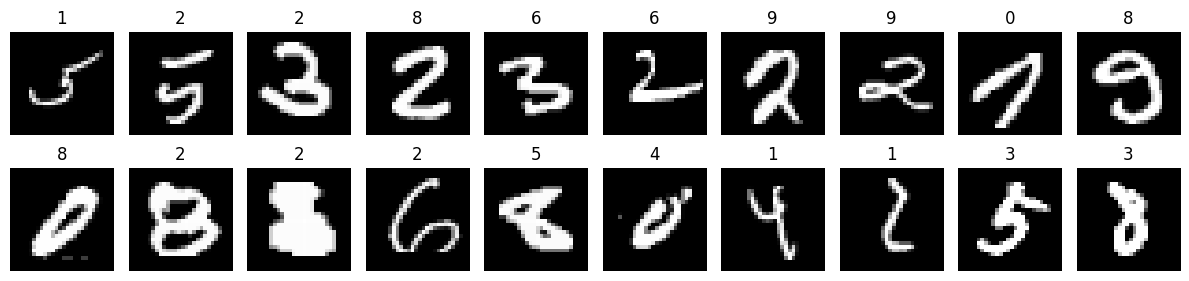

In [24]:
false_predic(next(iter(base_trainer.val_dataloader)))

# ***Base MLP Model***
#### While the linear model achieved "reasonable" performance, it had very ***narrow capacity***, limiting its ability to learn more complex patterns.
#### To further our analysis, we implement ***Multi-Layer-Perceptron***. Although we still treat images as flat vectors, adding hidden neurons enables the model to learn ***non-linear patterns***.
#####

## MLP One Hidden Layer Class
#### Simple MLP model with ***Stochastic Gradient Descent*** optimizer, ***Cross-Entropy Loss***.
#### In addition class contains essential functionality for later analysis i.e. Dropout, activation functions.

In [45]:
class BaseMLP(nn.Module):
    def __init__(self, num_outputs, num_hiddens, dropout_num, act_name, lr):
        super().__init__()
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        self.act_name = act_name
        self.lr = lr
        if self.act_name == 'ReLU':
            self.act_func = nn.ReLU()
        else:
            self.act_func = nn.Tanh()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(self.num_hiddens), self.act_func,
                                 nn.Dropout(dropout_num), nn.LazyLinear(self.num_outputs))
        
    def forward(self, X):
        return self.net(X)

    def ce_loss(self, Y_hat, Y):
        return F.cross_entropy(Y_hat, Y, reduction='mean')

    def config_optim(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def batch_step(self, batch):
        l = self.ce_loss(self.forward(batch[0]), batch[1])
        return l

## Training
#### 

### Model 1 - Base MLP ***(ReLU activation function)***

#### It can be seen that even simple MLP model with one hidden layer, achieves substantially lower train and val loss.
#### Upon closer inspection we can observe increasing difference between train and val loss **i.e. generalization gap**, meaning </br> that model may be beginning to fit more closely to train set, which after more extensive training may cause overfitting.

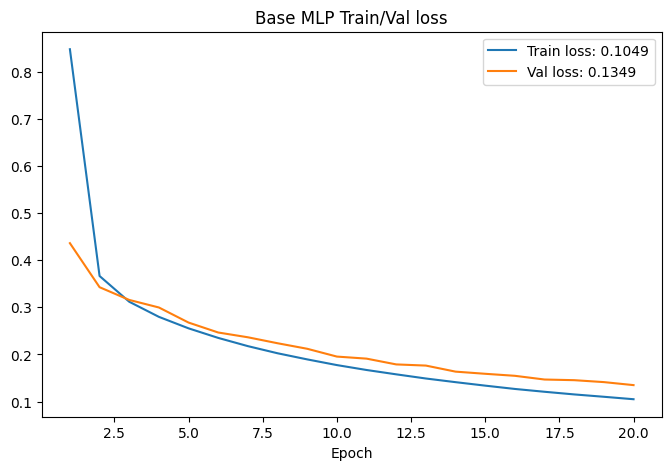

In [41]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(20)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

### Model 2 - Base MLP lower learning rate
#### Before moving on to Generalization, lets see how model will react to lower learning rate and compare it to base linear model.
#####

#### Despite ***decreasing learning rate***, simple MLP still achieves substantially lower train and val loss compared to base linear model.
#### This proves that adding hidden neurons enabled the model to learn ***non-linear patterns*** and thus perform significantly better.

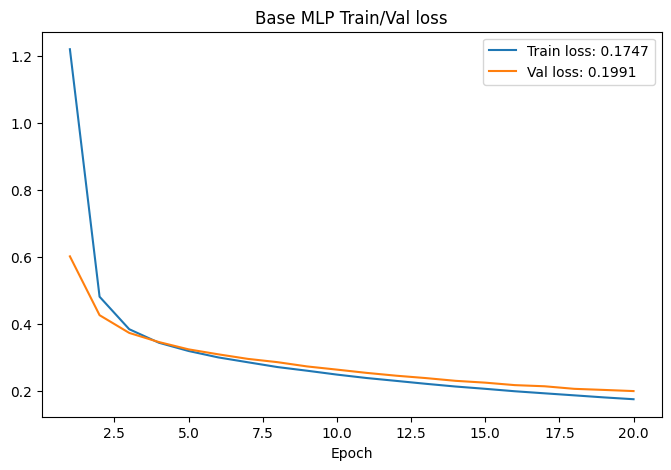

In [42]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.05)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(20)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

# ***Generalization***
#####

#### ***To further investigate behavior described in Model 1, we will train model with higher number of epochs.***
#### Despite increasing number of epochs, generalization gap has changed slighly, suggesting that the model capacity </br>is still well matched to the dataset. 

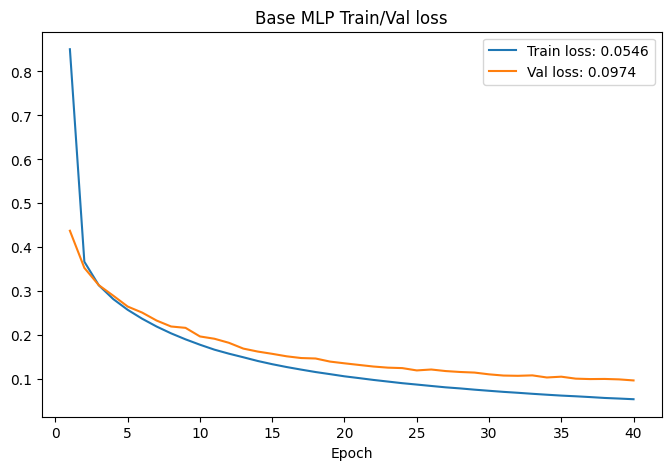

In [43]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### ***Let's see how increasing learning rate value to 0.2 will affect model's performance and generalization gap.***
####
#### Increased learning rate affected model's learning speed and made differences in losses much more visible.
#### Even though generalization gap is relatively low ***(~0.06)***, it is clear that model starts to fit more closely to train set.

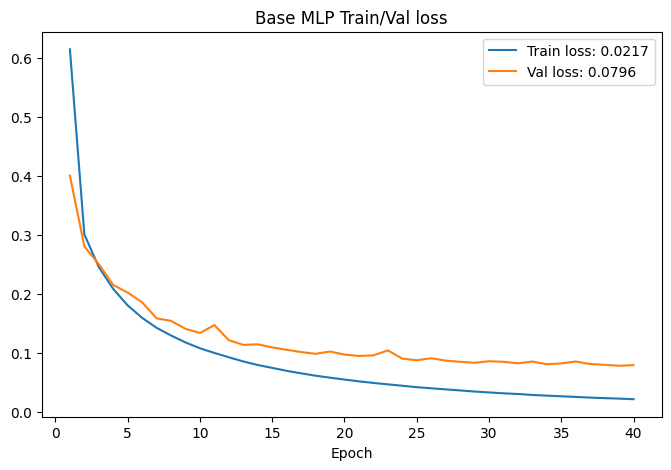

In [44]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0, act_name='ReLU', lr=0.2)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### ***Let's significantly increase number of hidden neurons to expand model's capacity.***
####
#### Suprisingly, training and validation loss changed just slighly, suggesting that adding extra neurons</br> to hidden neurons provided minimal benefit.

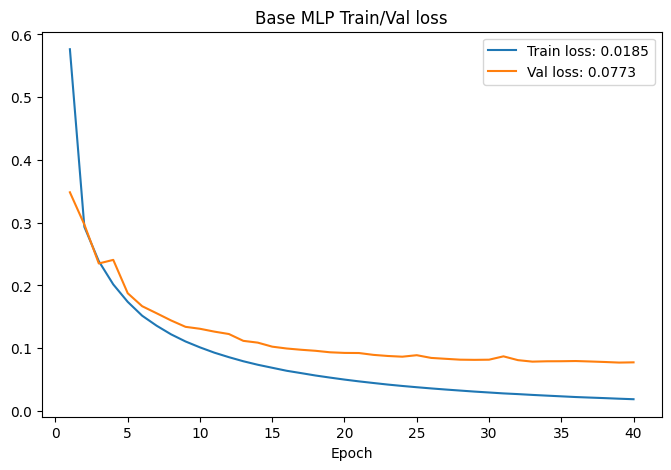

In [45]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0, act_name='ReLU', lr=0.2)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### ***Pushing the Generalization Gap: High Learning Rate Experiment***
#####
#### Increasing learning rate significantly reduced training loss, while validation loss stopped improving.
#### This suggests the model begins to memorize training patterns that do not generalize.

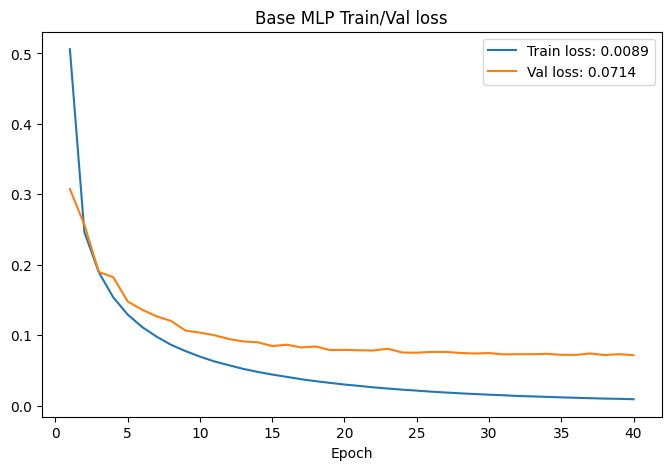

In [46]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0, act_name='ReLU', lr=0.3)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

## ***Implementing Dropout Generalization***
###

#### In order to help our model generalize better, thus improve it's performance on validation data, we implement dropout function.
#### We set ***dropout_num*** variable to 0.5, meaning that we will be removing half of our hidden neurons with each iteration.
####
#### Using Dropout Generalization led to slight decrease of validation loss and substantial training loss increase. </br>As a result of this, our generalization gap skrinked, making our model more stable.

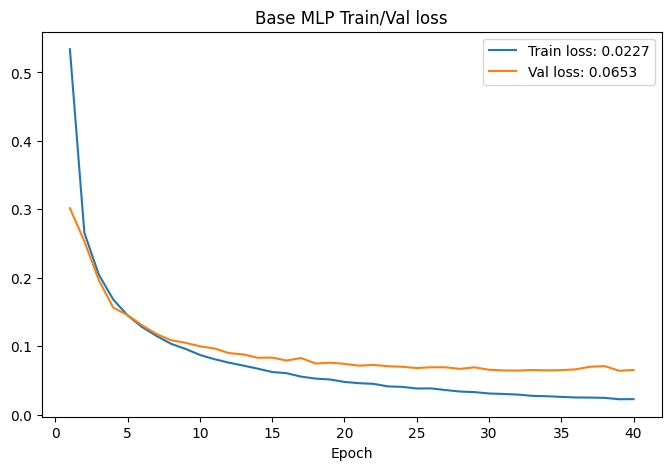

In [37]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=1024, dropout_num=0.5, act_name='ReLU', lr=0.3)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### After decresing number of hidden neurons to 256, we can observe that although training loss increased,</br> generalization gap is much lower and model is much more stable.

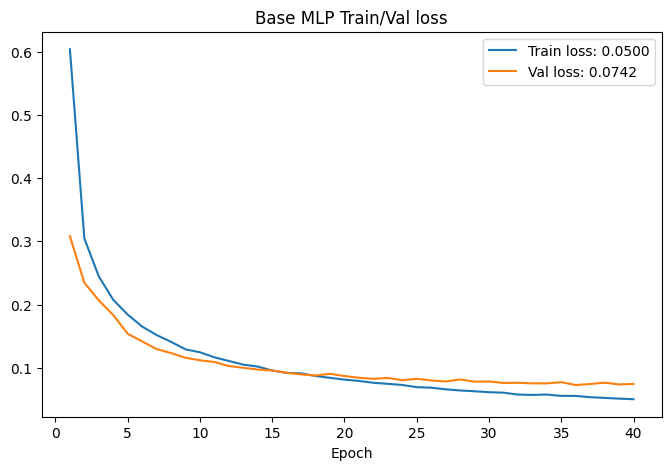

In [38]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.3)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### Validation loss stabilizes after ~40 epochs, suggesting the model has reached its effective capacity under current hyperparameters. Further training provides minimal benefit.

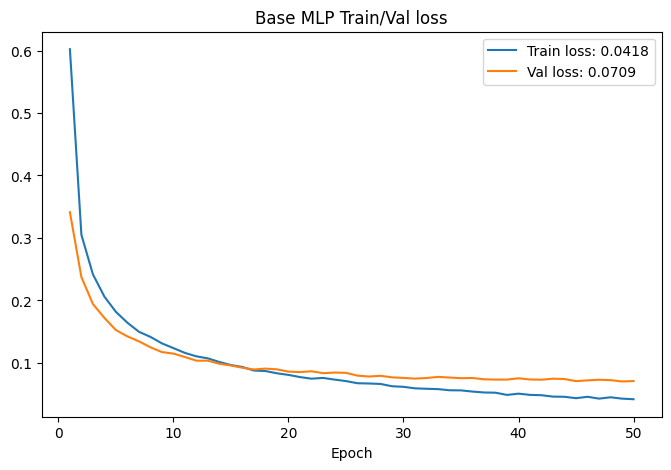

In [18]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.3)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(50)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### Although decreasing learning rate resulted in increase of both train and val loss, difference between them got minimal, </br>suggesting that model got much more stable.

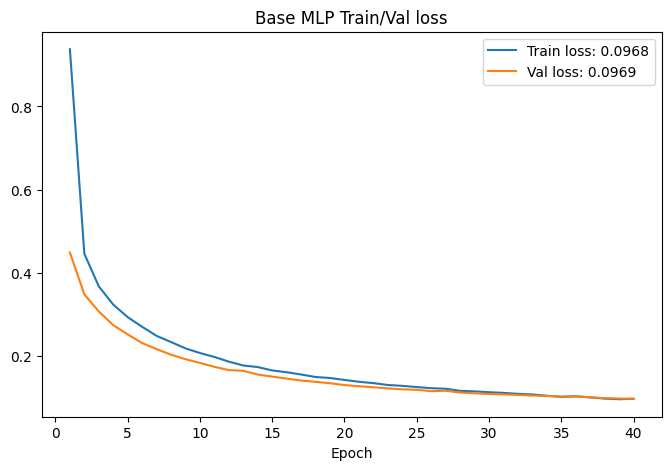

In [47]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(40)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

#### After training for over 80 epochs, validation loss is paroaching its optimal value.

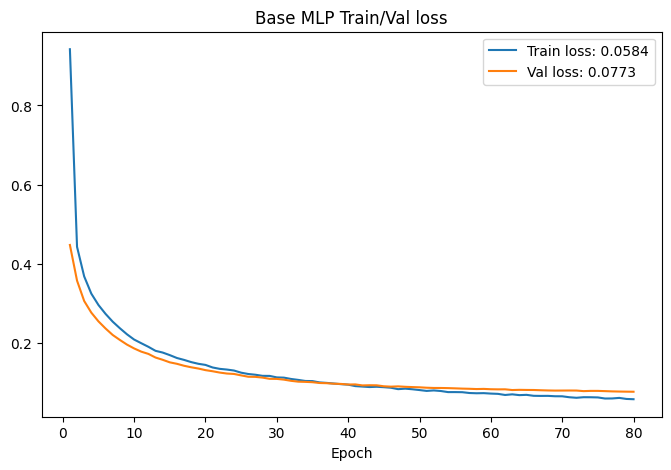

In [48]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='ReLU', lr=0.1)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(80)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

# Activation Function
#### Since activation functions introduce non-linearity, they may significantly affect optimization dynamics and model performance.
###

#### First of all train loss and val loss are substanially higher compared to Model with Relu.
#### It can be seen that Tanh has a lot slower convergence speed compared to ReLU, it may be explained by ReLU's</br> reduced vanishing gradient effect. 
#### Training with Tanh appears smoother, with fewer sudden loss changes.

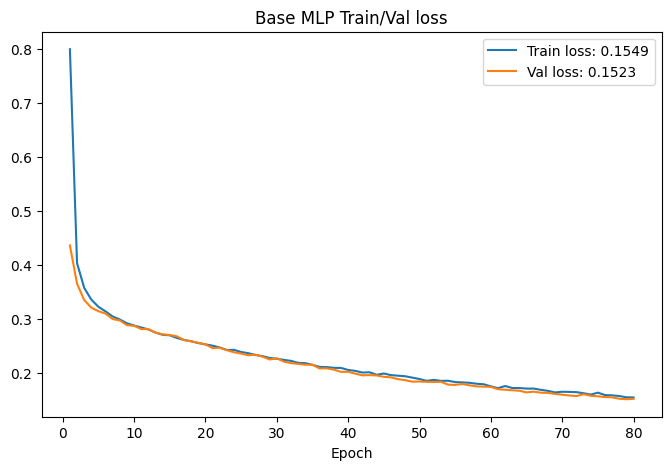

In [19]:
base_mlp = BaseMLP(num_outputs=10, num_hiddens=256, dropout_num=0.5, act_name='Tanh', lr=0.1)
plotter = Plotter("Base MLP Train/Val loss")
trainer = Trainer(80)
trainer.fit(base_mlp, train_tensor, val_tensor, plotter)

###

In [53]:
# train1 = base_trainer.train_losses_epoch
# val1 = base_trainer.val_losses_epoch
# acc1 = base_trainer.val_accuracy_epoch
# plotter = Plotter("Sigma")
# plotter.plot(train1, val1, acc1)
# plotter.plot([num + 1 for num in train1], val1, acc1)